In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
!pip uninstall kymatio
!rm -r /content/kymatio.egg-info
!rm -r /content/kymatio

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found existing installation: kymatio 0.2.1
Can't uninstall 'kymatio'. No files were found to uninstall.
rm: cannot remove '/content/kymatio.egg-info': No such file or directory


In [9]:
!git clone https://github.com/kymatio/kymatio.git
sys.path.append('/content/kymatio')
# !pip install -r kymatio/requirements.txt
# !python kymatio/setup.py install

# #!pip uninstall kymatio
# sys.path.append('/content/gdrive/MyDrive/scatter_signal_typing')
!pip install -e /content/kymatio

Cloning into 'kymatio'...
remote: Enumerating objects: 5108, done.
remote: Counting objects: 100% (581/581), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 5108 (delta 490), reused 437 (delta 437), pack-reused 4527
Receiving objects: 100% (5108/5108), 2.12 MiB | 24.66 MiB/s, done.
Resolving deltas: 100% (3342/3342), done.
Obtaining file:///content/kymatio
  Running setup.py develop for kymatio


In [10]:
import numpy as np
import os
from scipy.io import wavfile
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import math

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.multioutput import RegressorChain


# sys.path.append('/content/gdrive/MyDrive/scatter_signal_typing')
import torch
from kymatio.torch import Scattering1D


In [11]:
T = 2**16
file_path = '/content/gdrive/MyDrive/python_notebooks/grbas_capev/'
file_names = pd.read_csv(file_path + 'file_names.csv', header=None)
data = np.zeros((file_names.shape[1],T))
capev = pd.read_csv(file_path + 'capev_mean_ratings.csv', index_col = 0, header=0)
capev = capev.to_numpy()
labels = capev # 0: Severity, 1: Roughness, 2: Breathiness, 3: Strain, 
                    # 4: Pitch , 5: Loudness.

# Loading ratings matrices for category
severity = pd.read_csv(file_path + 'CAPE-V_Severity.csv', index_col = 0, header=0)
severity = severity.iloc[:,2::].to_numpy()

roughness = pd.read_csv(file_path + 'CAPE-V_Roughness.csv', index_col = 0, header=0)
roughness = roughness.iloc[:,2::].to_numpy()

breathiness = pd.read_csv(file_path + 'CAPE-V_Breathiness.csv', index_col = 0, header=0)
breathiness = breathiness.iloc[:,2::].to_numpy()

strain = pd.read_csv(file_path + 'CAPE-V_Strain.csv', index_col = 0, header=0)
strain = strain.iloc[:,2::].to_numpy()

pitch = pd.read_csv(file_path + 'CAPE-V_Pitch.csv', index_col = 0, header=0)
pitch = pitch.iloc[:,2::].to_numpy()

loudness = pd.read_csv(file_path + 'CAPE-V_Loudness.csv', index_col = 0, header=0)
loudness = loudness.iloc[:,2::].to_numpy()


for i in range(file_names.shape[1]):
  # print(file_names.iloc[0,i])
  _, x = wavfile.read(file_path +'sus_vocal_audio_files/'+ file_names.iloc[0,i])
  x = x/np.max(np.abs(x))
  L = np.max(x.shape)
  if L > T:
    data[i,:] = x[int(L // 2 - T // 2):int(L // 2 + T // 2)]
  else:
    start = (T - len(x)) // 2
    data[i,start:start + len(x)] = x

data = torch.tensor(data)
data = data.contiguous()
data = data.type(dtype=torch.float32)

In [12]:
def tv_feats(X,g):
    log_eps = 1e-6
    if g == 0:
      X = np.log(np.abs(X)+log_eps)
    else:
      X = np.power(np.abs(X)+log_eps, g)
    
    X = np.abs(np.diff(X))
    X = np.sum(X, axis=2)
    return X

def mean_coeffs(X,g):
    log_eps = 1e-6
    # X = np.log(np.abs(X)+log_eps)
    if g == 0:
      X = np.log(np.abs(X)+log_eps)
    else:
      X = np.power(np.abs(X)+log_eps, g)
    
    media = np.mean(X, axis = 2)
    devstd = np.std(X, axis = 2)
    
    return media, devstd

def get_scatt_coeficients(data, J, g):
    explained_var = 0
    n_comp = 0
    T = np.max(data.shape)
    scattering = Scattering1D(J, T, 1)

    meta = scattering.meta()
    order0 = np.where(meta['order'] == 0)
    order1 = np.where(meta['order'] == 1)
    order2 = np.where(meta['order'] == 2)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
      scattering.cuda()
      data = data.cuda()
    
    sx1 = scattering.forward(data)  
    if use_cuda:
      sx1 = sx1.cpu()
  
    sx  = sx1.numpy()
    media, devstd = mean_coeffs(sx,g)
    sx = tv_feats(sx, g)

    # media = media[:,np.concatenate((order1[0], order2[0]))]
    # devstd = devstd[:,np.concatenate((order1[0], order2[0]))]
    # sx = sx[:,np.concatenate((order1[0], order2[0]))]

    media = media[:, order2[0]]
    devstd = devstd[:, order2[0]]
    sx = sx[:, order2[0]]
    sx = np.concatenate((sx, media, devstd), axis = 1)

    # pca = PCA()
    # pca.fit(sx)
    # var_exp = pca.explained_variance_ratio_
    # for i in range(len(var_exp)):
    #   if np.sum(var_exp[0:i+1]) > 0.999 :
    #     n_comp = i+1
    #     explained_var = np.sum(var_exp[0:i+1])
    #     break
    
    # pdirs = pca.components_[0:n_comp]
    # sx = np.matmul(sx, np.transpose(pdirs))
    return sx, n_comp, explained_var

In [13]:
def label_correlation(x1,x2):
    x2 = x2.reshape(-1,1)
    x = np.concatenate((x1,x2), axis = 1)
    R = np.corrcoef(x, y=None, rowvar = False)
    return R


def hp_fun(X,y,K,sev = None,rou = None,bre = None,srt = None,pit = None,lou = None):
    """
    Feature extraction and clasification for hyperparameters estimation.
    Input:
      X: Data matrix, each column corresponds to one variable or feature.
      y: Label vector, each row corresponds to the label of the corresponding row in X.
      K: Number of folds for cross-validation, we use five-folds c-v for hp.
  
    Output:
      mean_acc: Mean accuracy for model selection.
    """

    kf = model_selection.KFold(n_splits=K)
    kf.get_n_splits(X)
    scaler = StandardScaler()  # Data normalization function

    R_sev = np.zeros((K,7,7))
    R_rou = np.zeros((K,7,7))
    R_bre = np.zeros((K,7,7))
    R_srt = np.zeros((K,7,7))
    R_pit = np.zeros((K,7,7))
    R_lou = np.zeros((K,7,7))
    mse = np.zeros((K, 1))
    acc = np.zeros((K, y.shape[1]))
    mout = np.zeros((K, y.shape[1]))

    y_acum = np.zeros((1,y.shape[1]))
    y_acum_hat = np.zeros((1,y.shape[1]))

    # SVR
    base_model = SVR(kernel = 'linear')
    model = RegressorChain(base_estimator = base_model )

    for k, (train_index, test_index) in enumerate(kf.split(y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_hat = np.abs(model.predict(X_test))

        if type(sev) is np.ndarray:
          sev_test,rou_test,bre_test = sev[test_index],rou[test_index],bre[test_index]
          srt_test,pit_test,lou_test = srt[test_index],pit[test_index],lou[test_index]
            
          R_sev[k] = label_correlation(sev_test,y_hat[:,0])
          R_rou[k] = label_correlation(rou_test,y_hat[:,1])
          R_bre[k] = label_correlation(bre_test,y_hat[:,2])
          R_srt[k] = label_correlation(srt_test,y_hat[:,3])
          R_pit[k] = label_correlation(pit_test,y_hat[:,4])
          R_lou[k] = label_correlation(lou_test,y_hat[:,5])
          

        y_acum = np.append(y_acum, y_test, axis = 0)
        y_acum_hat = np.append(y_acum_hat,y_hat, axis = 0)
        mse[k] = np.sqrt(mean_squared_error(y_test, y_hat))
        mout[k] = np.sqrt(mean_squared_error(y_test, y_hat, multioutput = 'raw_values'))
        
    mean_mse = np.mean(mse)
    std_mse = np.std(mse)
    mean_mout = np.mean(mout, axis = 0)
    std_mout = np.std(mout, axis = 0)
    
    y_acum = y_acum[1:]
    y_acum_hat = y_acum_hat[1:]
    
    return mean_mse, y_test, y_hat, mean_mout, std_mse, std_mout, (R_sev,R_rou,R_bre,R_srt,R_pit,R_lou), (y_acum, y_acum_hat)

In [14]:
# Parameters and hyperparameters array
J = np.array([i for i in range(3,14)])
G = np.arange(0, 1.1, 0.1)
mse = np.zeros((len(J),len(G)))
use_cuda = torch.cuda.is_available()
if use_cuda:
  print('Using cuda...')
else:
  print('Not using cuda')

min_mse = math.inf
for j in range(len(J)):
    print(J[j])
    for g in range(len(G)):
      X, n_comp, exp_var = get_scatt_coeficients(data, J[j], G[g])        

      # Partition data into hyperparameters determination and validation sets.
      sets = model_selection.train_test_split(X, labels,
                      severity, roughness, breathiness, strain, pitch, loudness,
                                                  test_size = 0.2, shuffle=True,
                                                  random_state = 42)

      X_val, X_hp, y_val, y_hp = sets[0:4]

      X_hp = np.nan_to_num(X_hp)
      X_val = np.nan_to_num(X_val)
      mse[j,g],_,_,_,_,_,_,_ = hp_fun(X_hp, y_hp, 5)

      if mse[j,g] < min_mse:
        min_mse = mse[j,g]
        J_min = J[j]
        G_min = G[g]
        X_val_min = X_val
        y_val_min = y_val
        exp_var_min = exp_var
        n_comp_min = n_comp
        sev,rou,bre,srt,pit,lou = sets[4::2]

print('J = {}, g = {}'.format(J_min, G_min))

mean_mse, y_test, y_hat, mean_mout, std_mse, std_mout, Rmats, acums = hp_fun(X_val_min, y_val_min,10, sev, rou, bre, srt, pit, lou)
print('Mean mse:{}'.format(mean_mse))
print('Stf mse:{}'.format(std_mse))
print('Mean mout:{}'.format(mean_mout))
print('Std mout:{}'.format(std_mout))

Using cuda...
3
4
5
6
7
8
9
10
11
12
13
J = 7, g = 0.1
Mean mse:15.19345366200954
Stf mse:1.591063490398758
Mean mout:[16.50838258 13.70073138 14.25442391 15.32765951 15.06041392 15.6632908 ]
Std mout:[1.62463182 2.40247154 1.91267604 2.05530148 2.80592854 2.35600238]


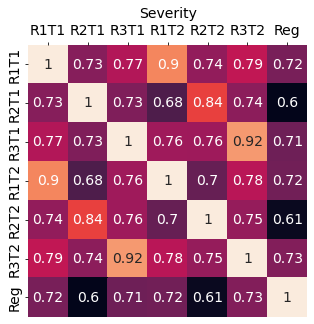

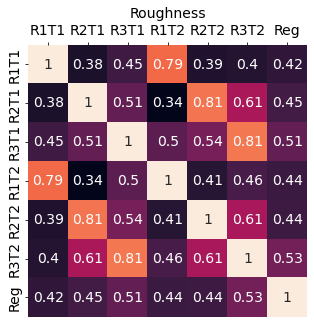

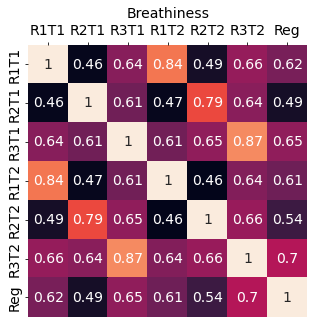

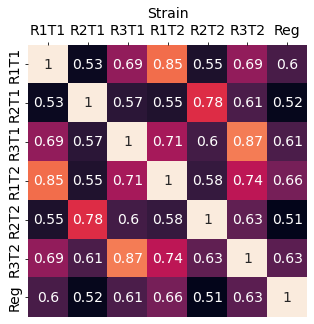

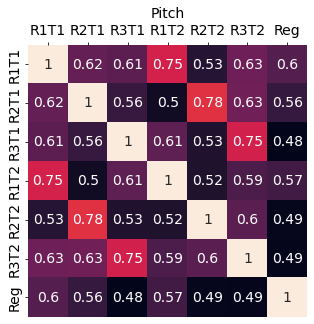

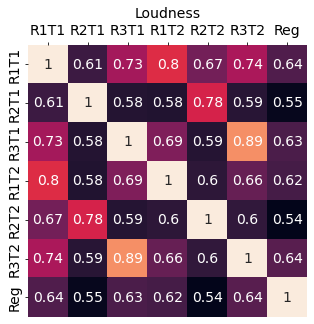

In [15]:
# Correlation matrices
corr_labels = ['R1T1','R2T1','R3T1','R1T2','R2T2','R3T2','Reg']
aspects_names = ['Severity', 'Roughness','Breathiness','Strain','Pitch','Loudness']
for i, r in enumerate(Rmats):
  fig = plt.figure()
  dfr = pd.DataFrame(np.mean(r, axis = 0))
  dfr.columns = corr_labels
  dfr.index  = corr_labels
  mask = np.tril(np.mean(dfr, axis = 0))
  corrtable = sns.heatmap(dfr, annot=True, cbar=False, annot_kws={"size": 14})

  corrtable.xaxis.set_label_position('top') 
  corrtable.xaxis.tick_top()
  corrtable.set_xticklabels(corrtable.get_yticklabels(), horizontalalignment='center', fontsize = 14)
  corrtable.set_yticklabels(corrtable.get_yticklabels(), verticalalignment='center', fontsize = 14)
  plt.title(aspects_names[i], fontsize = 14)
  fig.set_size_inches((5,5))
  filename = '/content/gdrive/MyDrive/python_notebooks/cm_' + aspects_names[i]
  plt.savefig(filename + '.pdf',bbox_inches='tight')# , format='svg')